In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
import pylab

In [35]:
# Load the data from the CSV file
sales_data = pd.read_csv('sales_data.csv')
sales_data.head(10)

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear,datetime
0,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06,2011-05-31
1,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06,2011-05-31
2,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06,2011-05-31
3,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06,2011-05-31
4,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06,2011-05-31
5,1,3578.2700,3578.2700,3953.9884,Bikes,United States,1.051085e+07,5.366576e+06,2011-06-01
6,1,3578.2700,3578.2700,3953.9884,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
7,1,3374.9900,3374.9900,3729.3640,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
8,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
9,1,3578.2700,3578.2700,3953.9884,Bikes,United States,1.051085e+07,5.366576e+06,2011-06-02


In [36]:
# Convert 'datetime' column to datetime type
sales_data['datetime'] = pd.to_datetime(sales_data['datetime'])

# Set 'datetime' as the index
sales_data.set_index('datetime', inplace=True)
sales_data.head()

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06
2011-05-31,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06


In [37]:
categories = sales_data['Category'].unique()
categories.size

4

In [38]:
sales_data_category = {category: sales_data[sales_data['Category'] == category] for category in categories}


sales_data_category[categories[0]]
    

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06
2011-05-31,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06
...,...,...,...,...,...,...,...,...
2014-05-30,1,539.9900,539.9900,639.1983,Bikes,United Kingdom,5.012905e+06,1.635823e+06
2014-05-30,1,2384.0700,2384.0700,2673.0613,Bikes,Germany,3.805202e+06,1.307950e+06
2014-05-30,1,2384.0700,2384.0700,2634.3974,Bikes,Australia,5.977815e+06,2.278549e+06


In [39]:
# Resample 'TotalDue' for each category in the dictionary
monthly_sales_by_category = {
    category: data['TotalDue'].resample('ME').sum() for category, data in sales_data_category.items()
}

# Example: Access the resampled data for the first category
first_category = categories[0]
print(f"Monthly sales for category '{first_category}':")
print(monthly_sales_by_category[first_category])

Monthly sales for category 'Bikes':
datetime
2011-05-31    3.326728e+06
2011-06-30    5.070965e+05
2011-07-31    8.957059e+06
2011-08-31    1.359668e+07
2011-09-30    5.547916e+05
2011-10-31    3.107267e+07
2011-11-30    8.153130e+05
2011-12-31    6.936427e+06
2012-01-31    2.865410e+07
2012-02-29    8.545708e+06
2012-03-31    1.912188e+07
2012-04-30    1.319654e+07
2012-05-31    3.300233e+07
2012-06-30    5.257967e+07
2012-07-31    3.759543e+07
2012-08-31    2.643862e+07
2012-09-30    4.404652e+07
2012-10-31    2.963184e+07
2012-11-30    1.829066e+07
2012-12-31    3.466899e+07
2013-01-31    2.093356e+07
2013-02-28    2.562925e+07
2013-03-31    4.299064e+07
2013-04-30    2.748088e+07
2013-05-31    3.474028e+07
2013-06-30    5.514830e+07
2013-07-31    5.438859e+07
2013-08-31    2.893463e+07
2013-09-30    4.304085e+07
2013-10-31    4.890452e+07
2013-11-30    2.201749e+07
2013-12-31    3.471363e+07
2014-01-31    3.743731e+07
2014-02-28    1.424373e+06
2014-03-31    6.889013e+07
2014-04-30

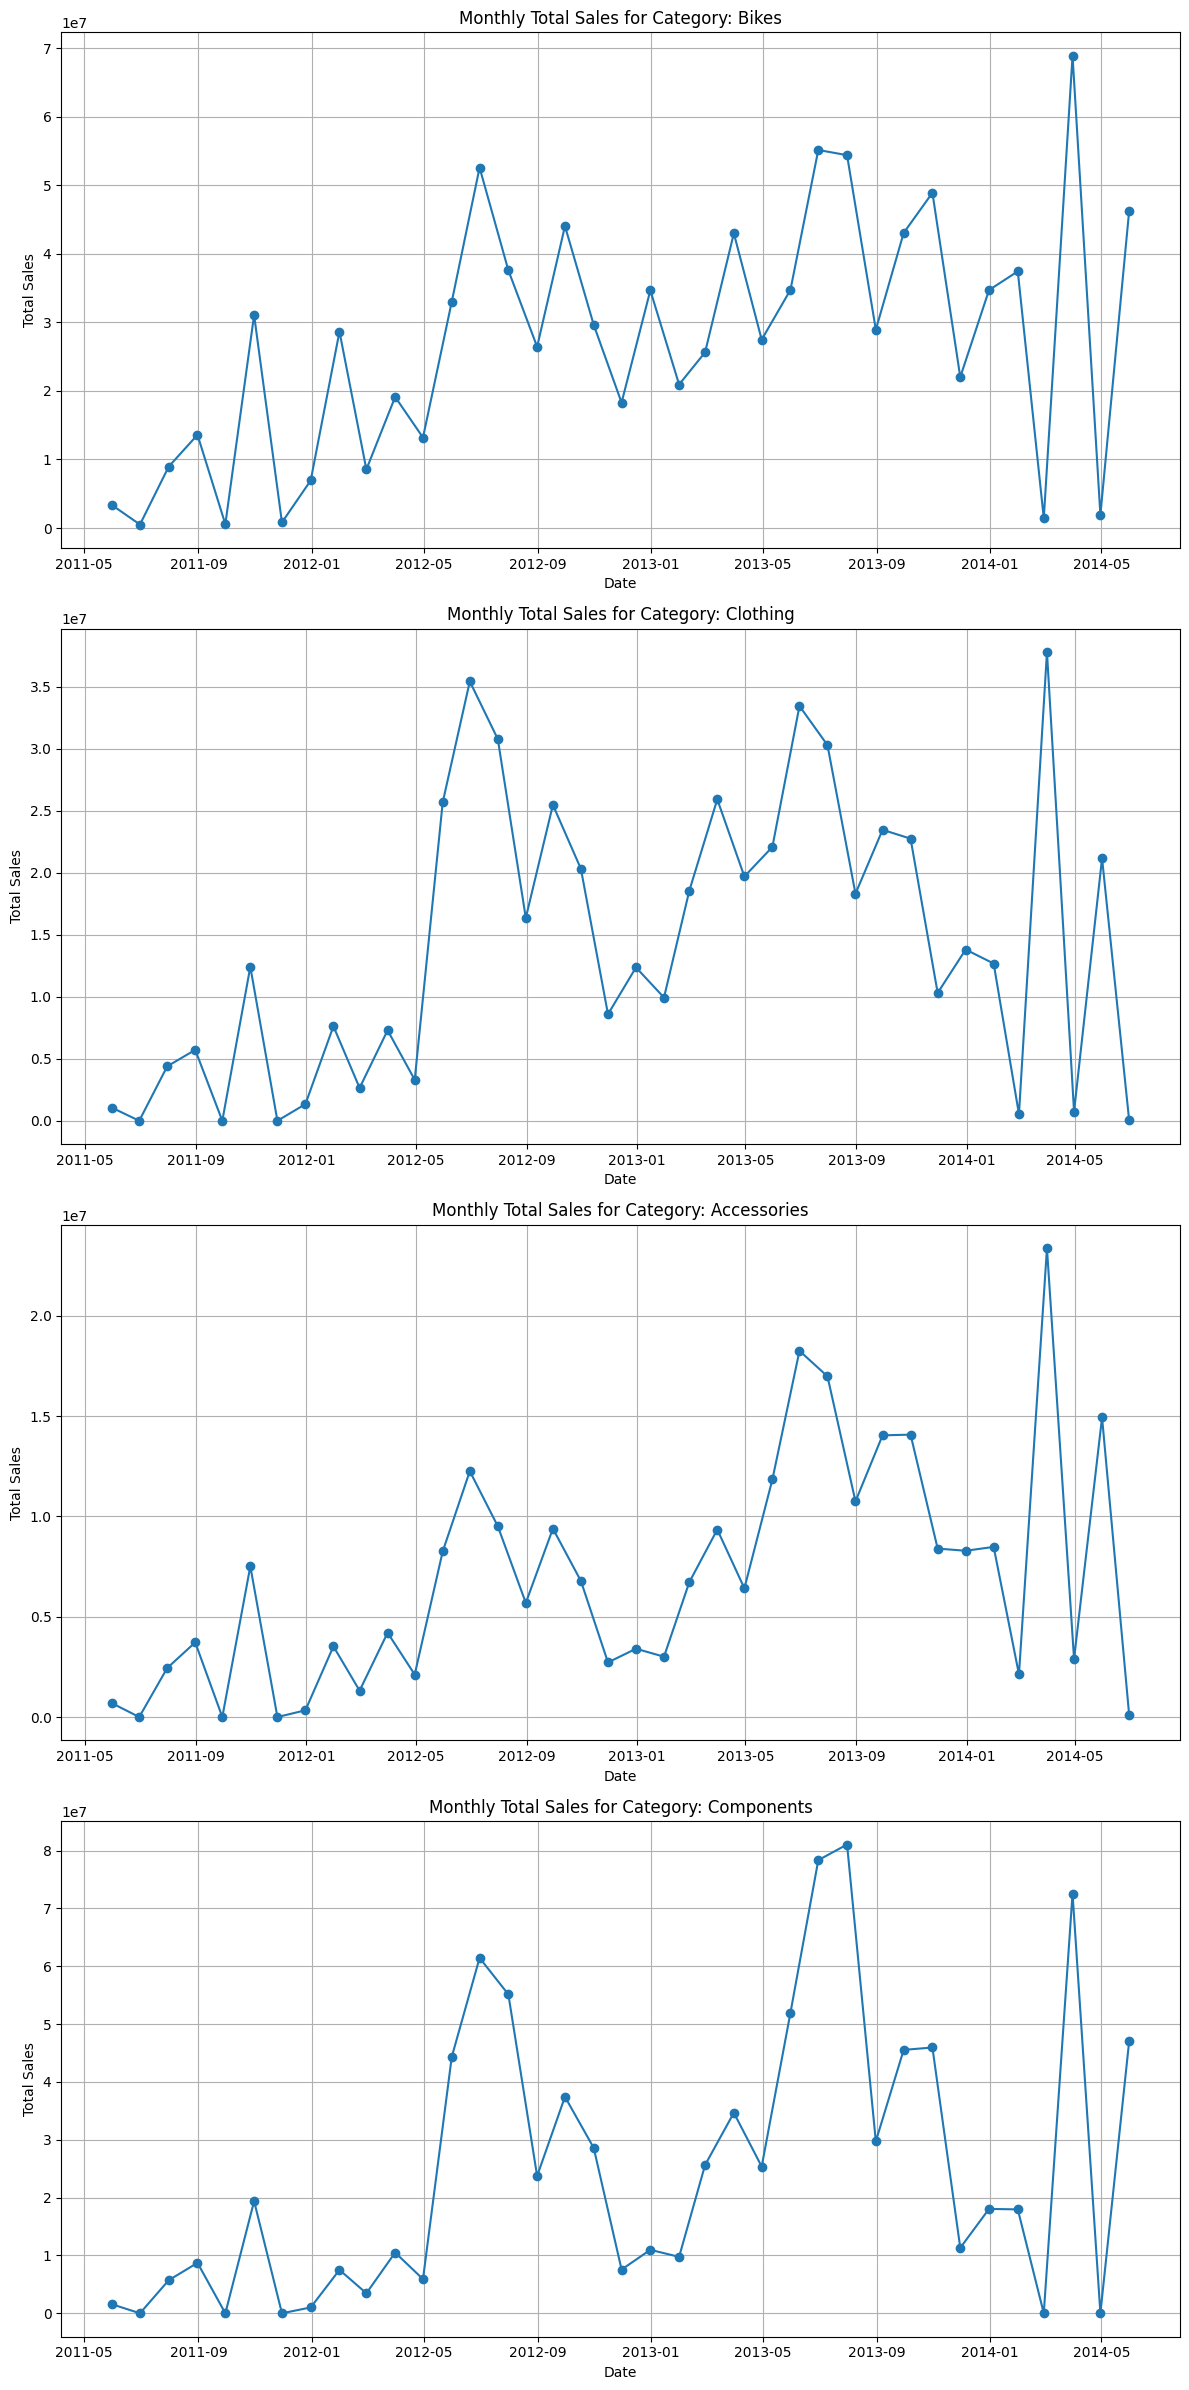

In [40]:
n_categories = len(categories)  # Total number of categories

plt.figure(figsize=(12, 6 * n_categories))  # Adjust figure size dynamically based on the number of categories

for i, (category, monthly_sales) in enumerate(monthly_sales_by_category.items(), 1):
    plt.subplot(n_categories, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for Category: {category}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [44]:
def adf_test(series):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(series)
    #print('ADF Statistic:', result[0])
    #print('p-value:', result[1])
    # for key, value in result[4].items():
    #     print('Critical Value (%s): %.3f' % (key, value))
        
    return result[1]

# Perform ADF test
for (category, data) in monthly_sales_by_category.items():
    print(f'{category}')
    print(adf_test(data))

Bikes
3.089118835506094e-06
Clothing
0.0009872908808745847
Accessories
9.928241239898757e-08
Components
0.006404803132355289


In [43]:
#Make the time series stationary
for (category, data) in monthly_sales_by_category.items():
    p_value = adf_test(data)
    
    if p_value > 0.05:
        print(f"\nCategory: {category}")
        differenced_data = data.diff().dropna()
        monthly_sales_by_category[category] = differenced_data
        print(adf_test(differenced_data))


Category: Accessories
9.928241239898757e-08


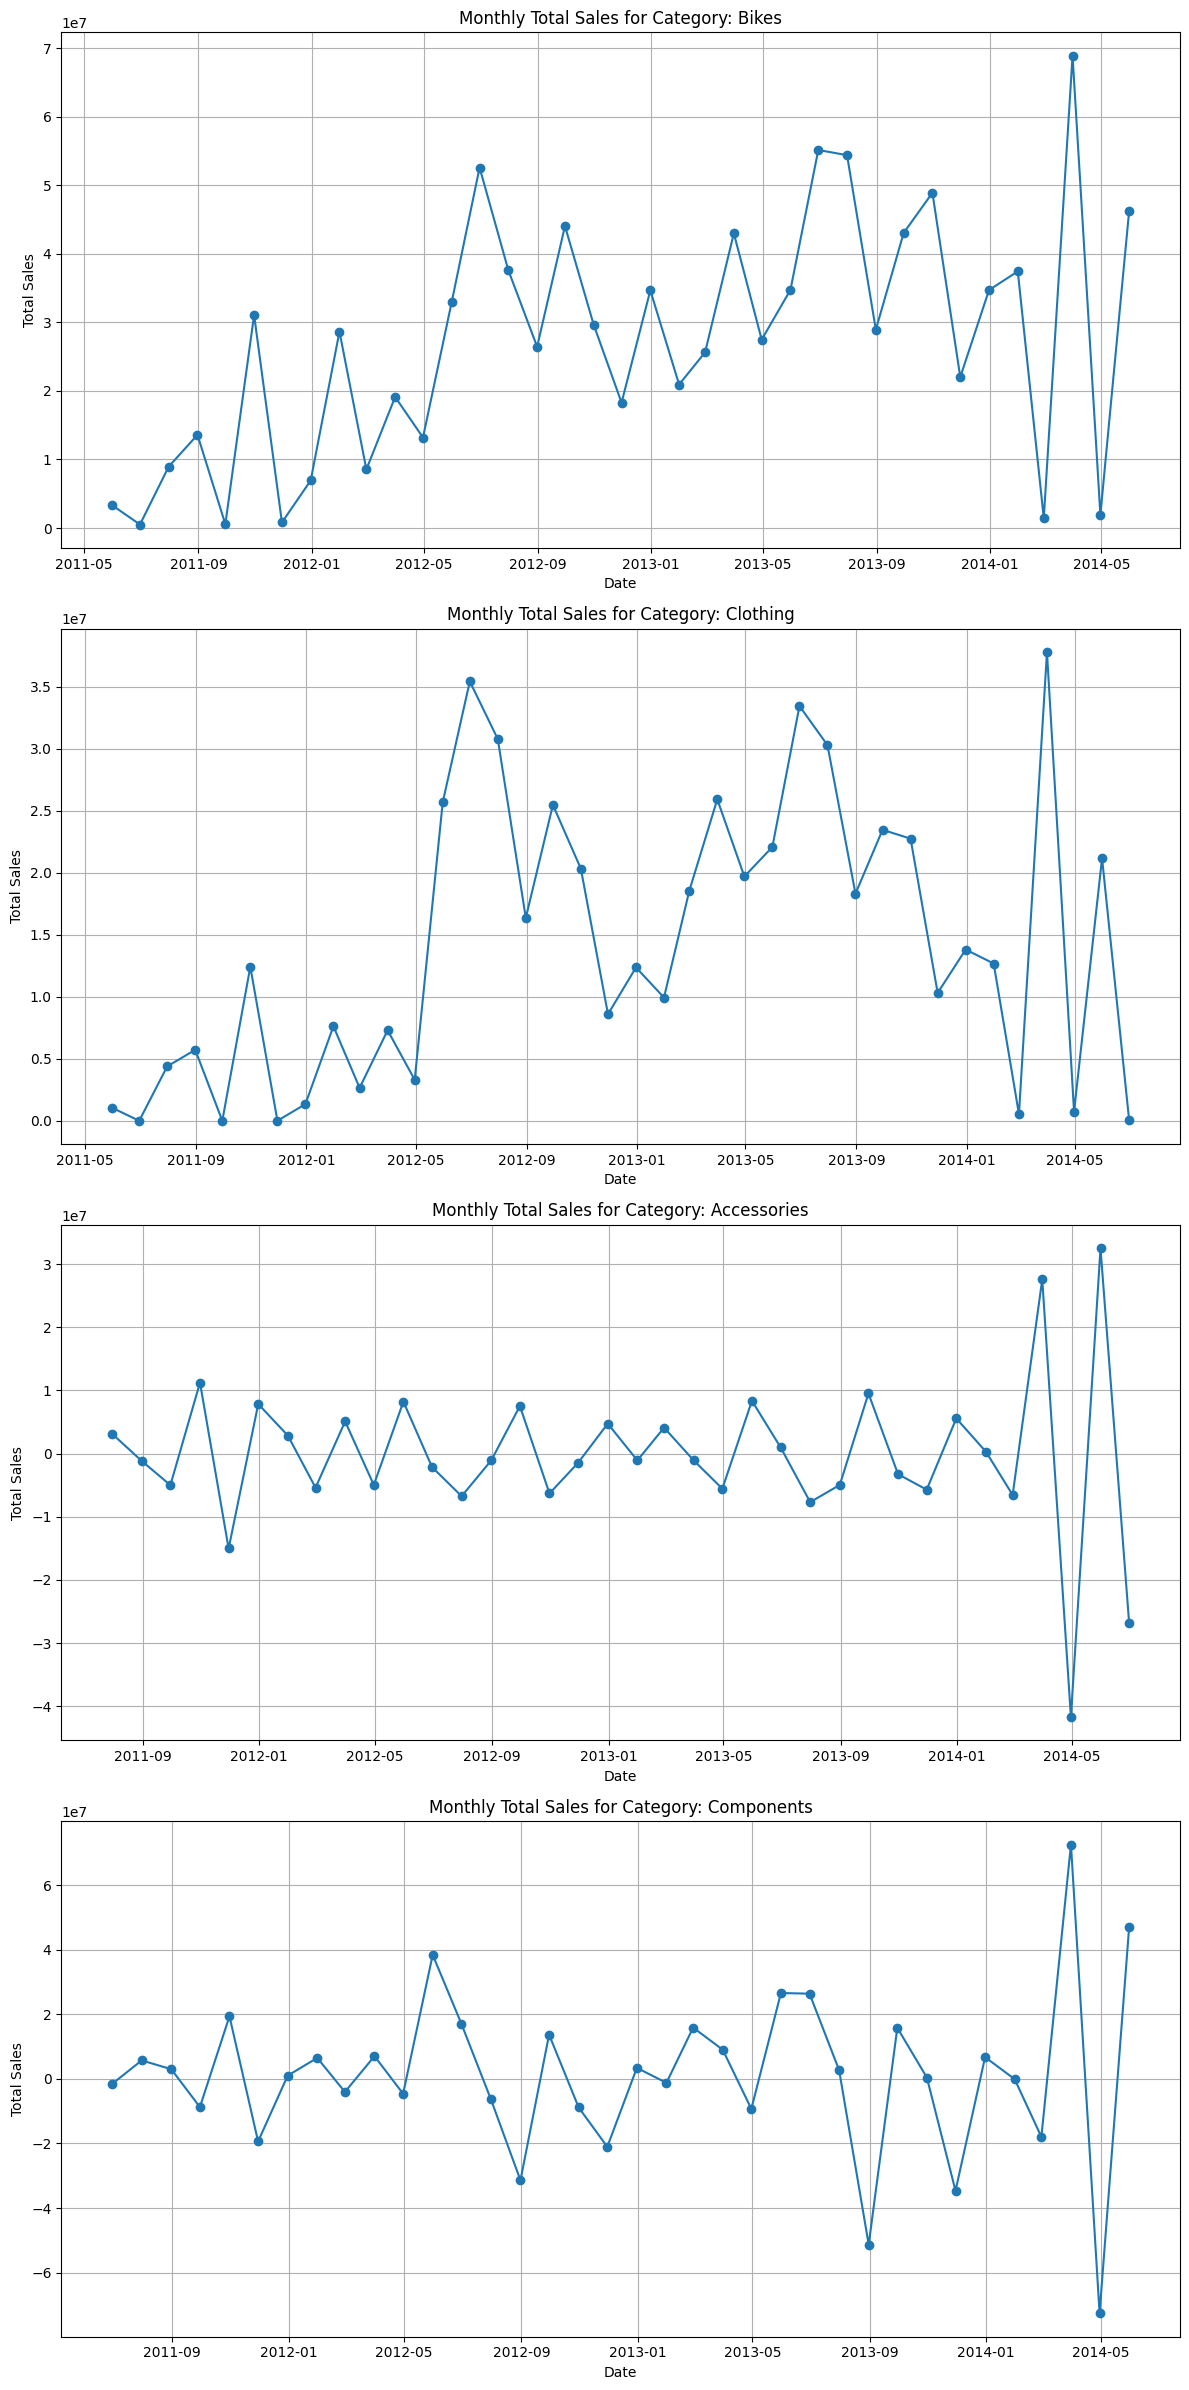

In [45]:
n_categories = len(categories)  # Total number of categories

plt.figure(figsize=(12, 6 * n_categories))  # Adjust figure size dynamically based on the number of categories

for i, (category, monthly_sales) in enumerate(monthly_sales_by_category.items(), 1):
    plt.subplot(n_categories, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for Category: {category}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

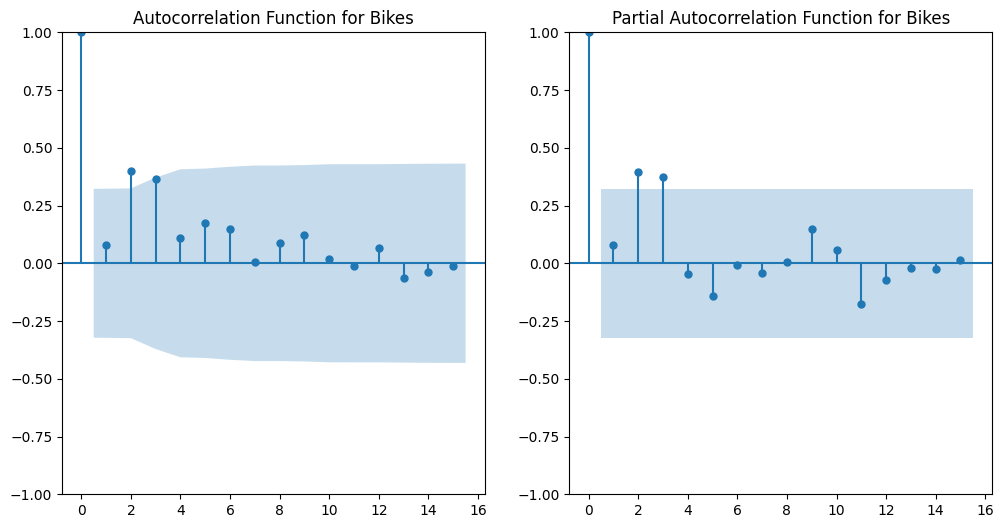

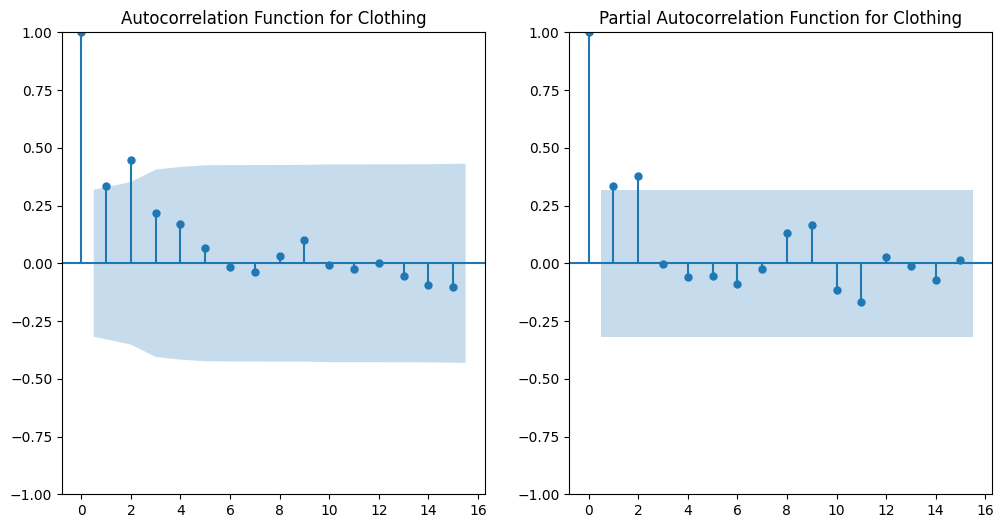

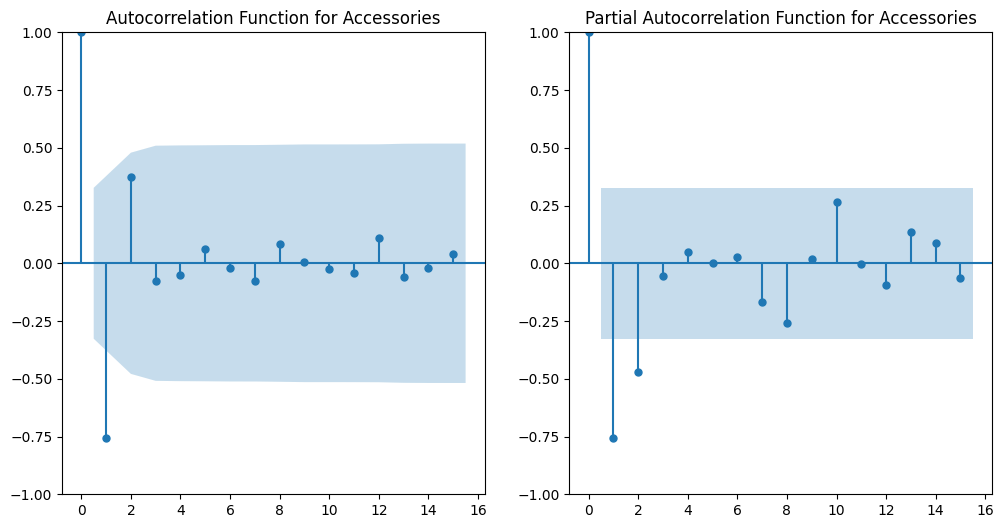

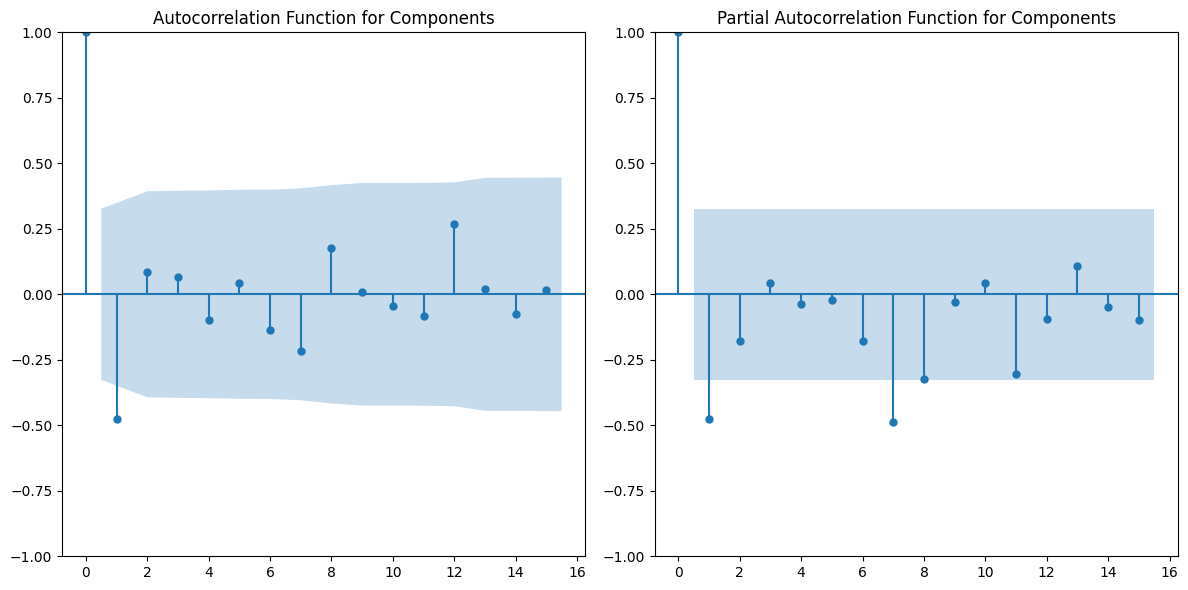

In [46]:
# Define maximum lags (adjust as necessary)
max_lags = 15

# Loop through each category and plot ACF and PACF
for category, monthly_sales in monthly_sales_by_category.items():
    plt.figure(figsize=(12, 6))
    
    # Plot ACF
    plt.subplot(121)
    plot_acf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Autocorrelation Function for {category}')
    
    # Plot PACF
    plt.subplot(122)
    plot_pacf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Partial Autocorrelation Function for {category}')
    
plt.tight_layout()
plt.show()

In [47]:
# Define the model
model_bikes = ARIMA(monthly_sales_by_category[categories[0]], order=(3, 0, 3))
model_clothing = ARIMA(monthly_sales_by_category[categories[1]], order=(2, 0, 2))
model_accessories = ARIMA(monthly_sales_by_category[categories[2]], order=(2, 0, 1))
model_components = ARIMA(monthly_sales_by_category[categories[3]], order=(8, 0, 1))



In [48]:
model_fit_bikes = model_bikes.fit()

In [49]:
model_fit_clothing = model_clothing.fit()

In [50]:
model_fit_accessories = model_accessories.fit()

In [51]:
model_fit_components = model_components.fit()

c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


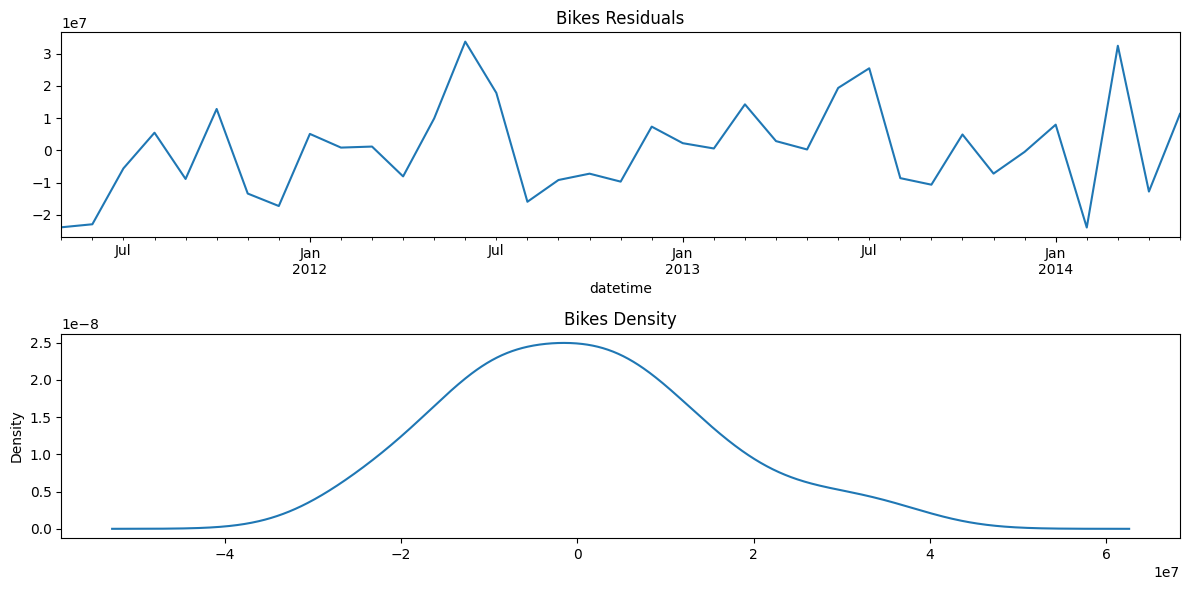

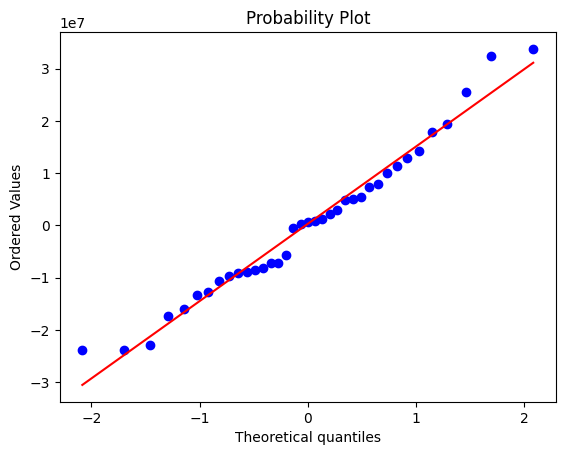

In [53]:
# Plot residuals
residuals = model_fit_bikes.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
residuals.plot(title="Bikes Residuals", ax=plt.gca())

plt.subplot(212)
residuals.plot(kind='kde', title='Bikes Density', ax=plt.gca())

plt.tight_layout()
plt.show()

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()


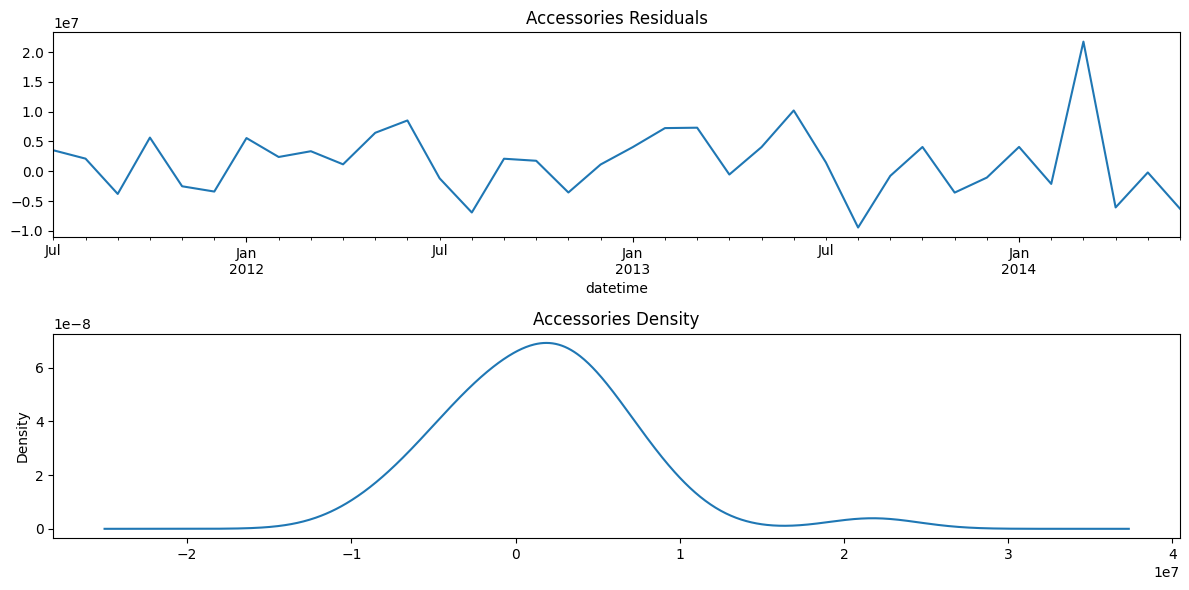

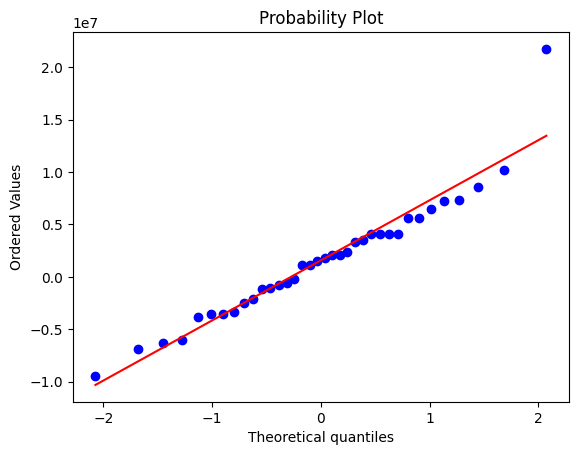

In [54]:
# Plot residuals
residuals = model_fit_accessories.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
residuals.plot(title="Accessories Residuals", ax=plt.gca())

plt.subplot(212)
residuals.plot(kind='kde', title='Accessories Density', ax=plt.gca())

plt.tight_layout()
plt.show()

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()


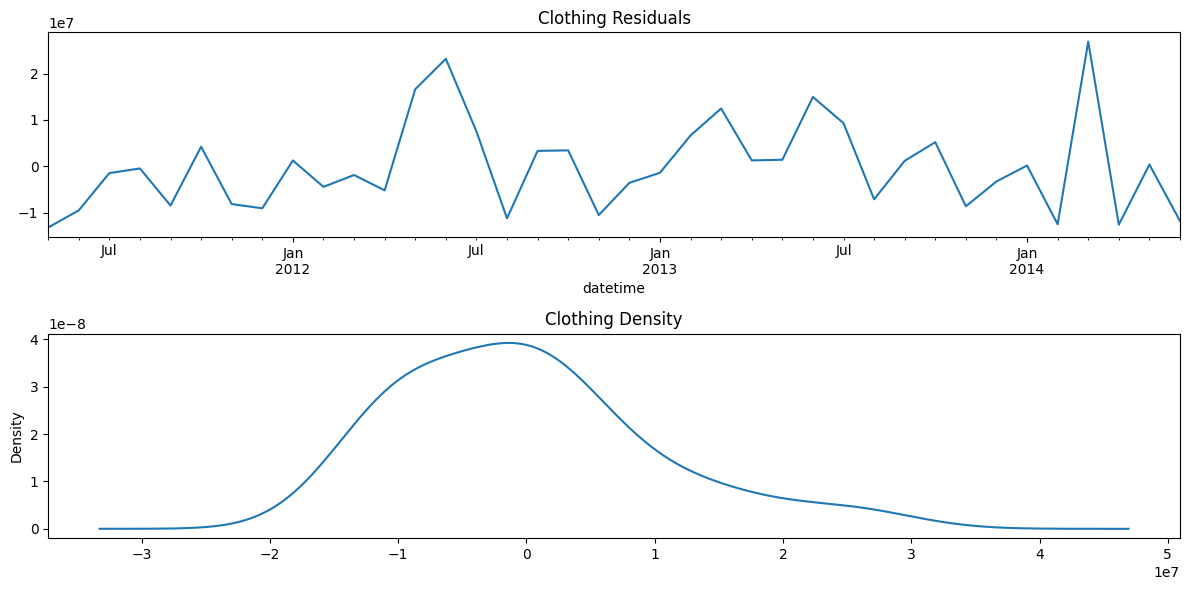

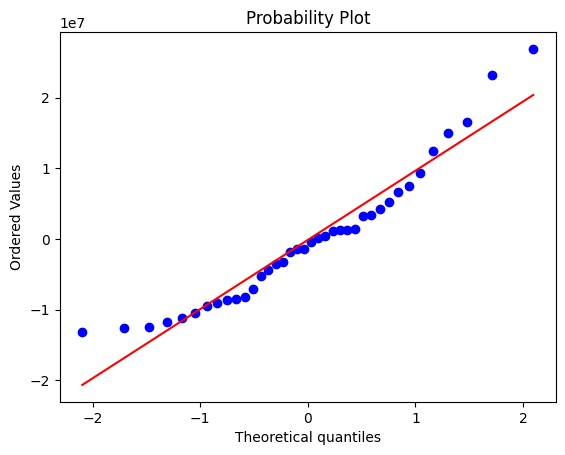

In [55]:
# Plot residuals
residuals = model_fit_clothing.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
residuals.plot(title="Clothing Residuals", ax=plt.gca())

plt.subplot(212)
residuals.plot(kind='kde', title='Clothing Density', ax=plt.gca())

plt.tight_layout()
plt.show()


stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

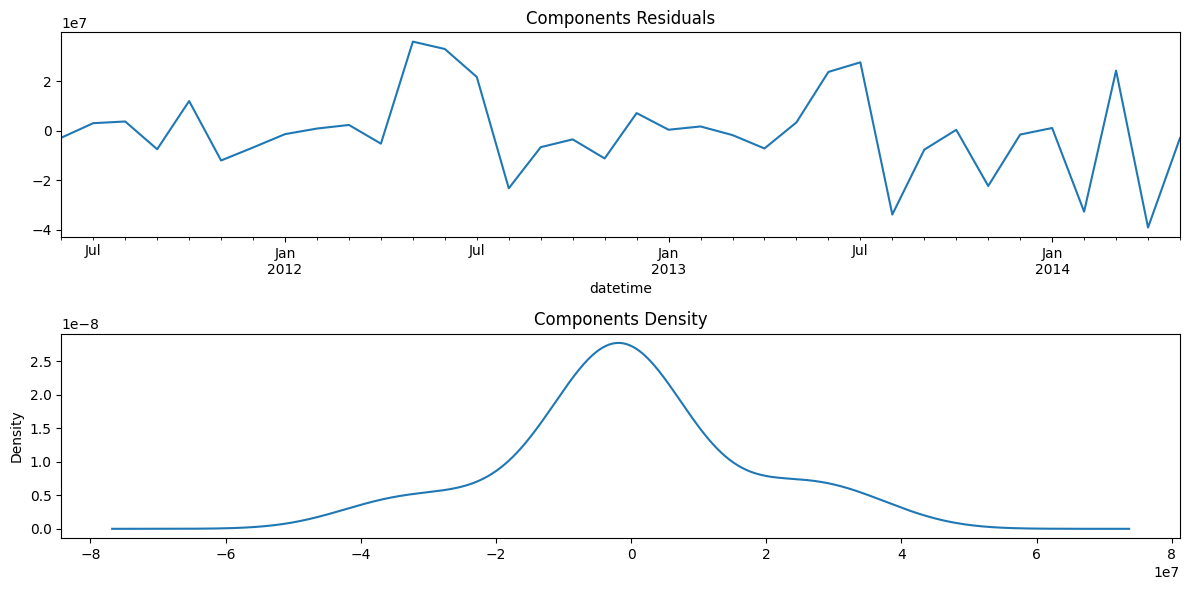

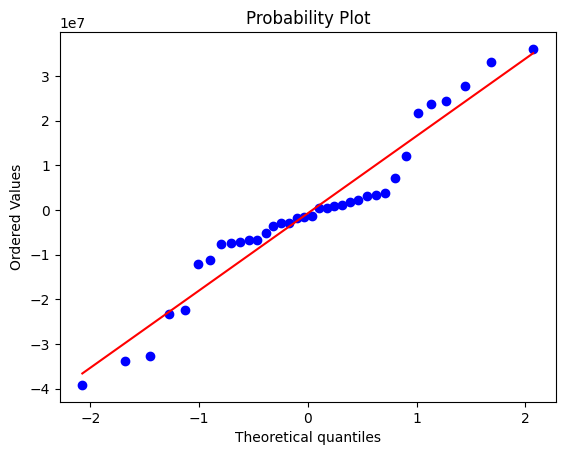

In [56]:
# Plot residuals
residuals = model_fit_components.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
residuals.plot(title="Components Residuals", ax=plt.gca())

plt.subplot(212)
residuals.plot(kind='kde', title='Components Density', ax=plt.gca())

plt.tight_layout()
plt.show()

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()


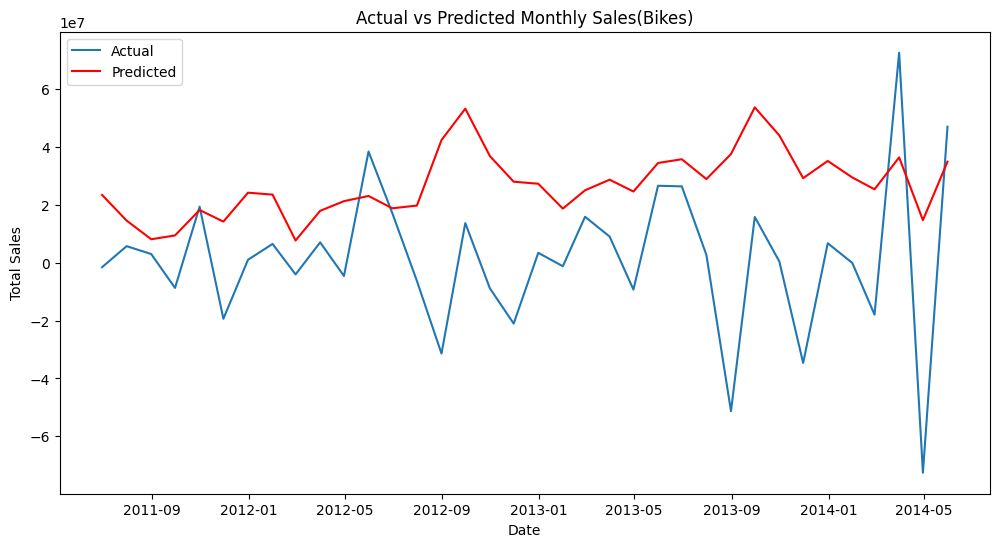

In [57]:
# In-sample prediction
predictions = model_fit_bikes.predict(start=monthly_sales_by_category['Bikes'].index[1], end=monthly_sales_by_category['Bikes'].index[-1], typ='levels')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Monthly Sales(Bikes)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


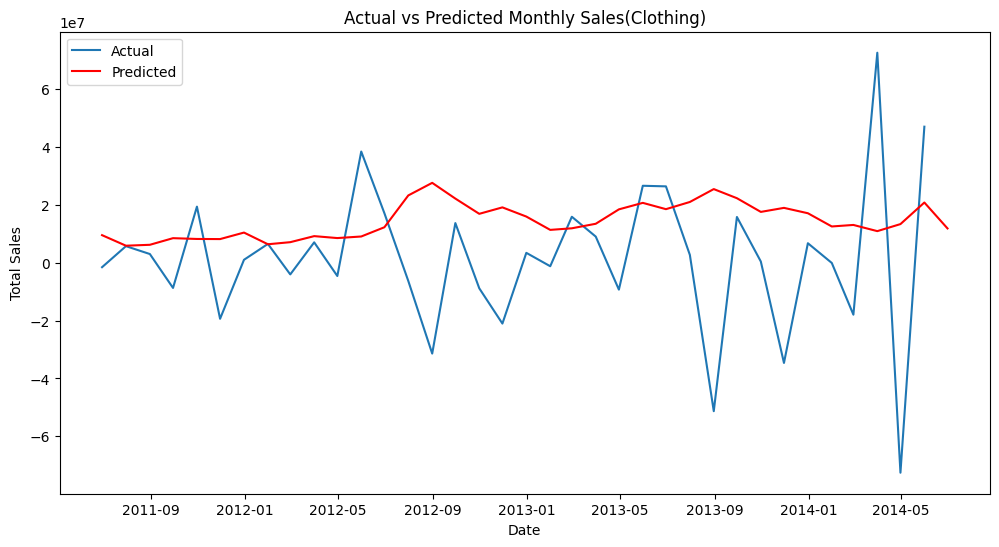

In [58]:
# In-sample prediction
predictions = model_fit_clothing.predict(start=monthly_sales_by_category['Clothing'].index[1], end=monthly_sales_by_category['Clothing'].index[-1], typ='levels')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Monthly Sales(Clothing)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

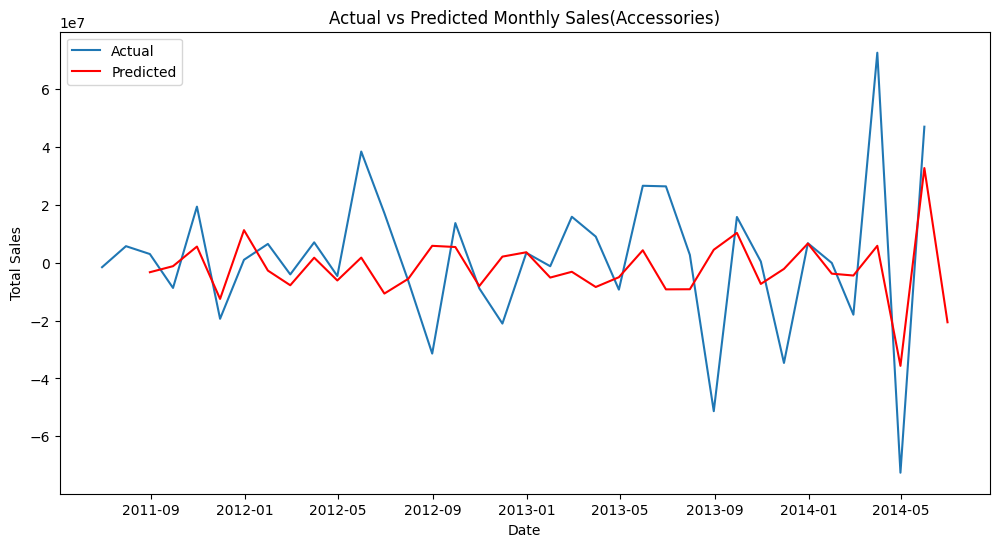

In [59]:
# In-sample prediction
predictions = model_fit_accessories.predict(start=monthly_sales_by_category['Accessories'].index[1], end=monthly_sales_by_category['Accessories'].index[-1], typ='levels')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Monthly Sales(Accessories)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

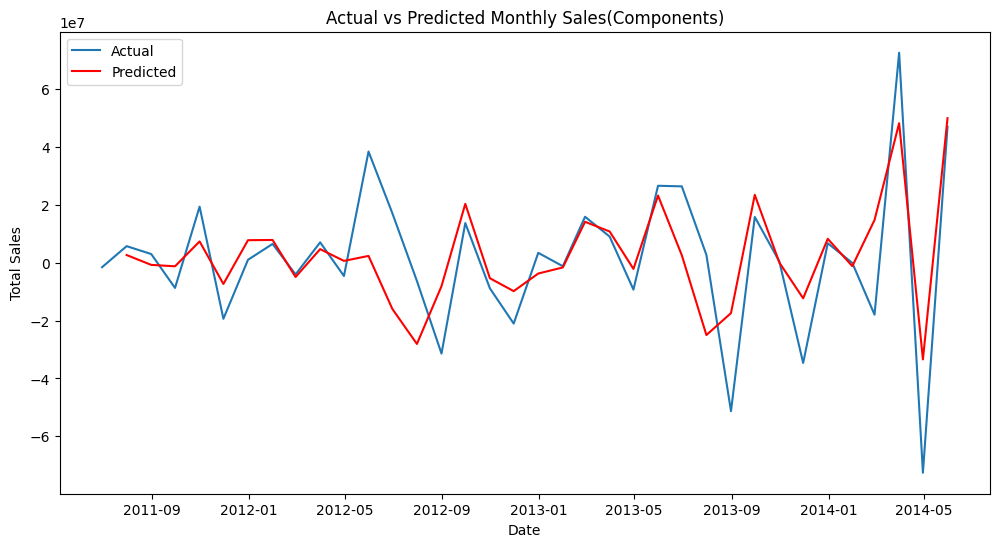

In [60]:
# In-sample prediction
predictions = model_fit_components.predict(start=monthly_sales_by_category['Components'].index[1], end=monthly_sales_by_category['Components'].index[-1], typ='levels')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Monthly Sales(Components)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

C:\Users\Hi There\AppData\Local\Temp\ipykernel_36488\1746490742.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


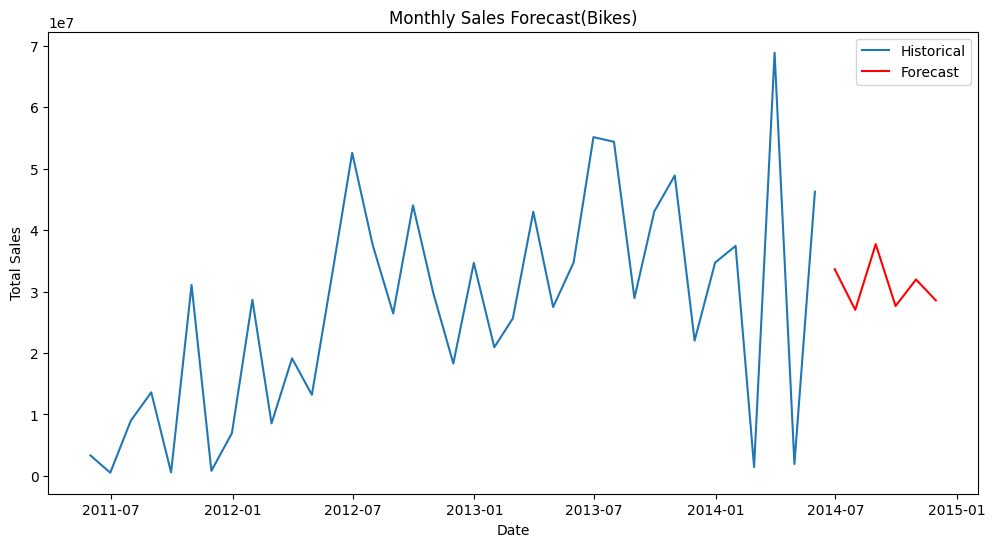

In [61]:
# Forecasting
forecast_steps = 6
forecast = model_fit_bikes.forecast(steps=forecast_steps)

# Create future dates
last_date = monthly_sales_by_category['Bikes'].index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Create forecast series
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_by_category['Bikes'], label='Historical')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Monthly Sales Forecast(Bikes)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

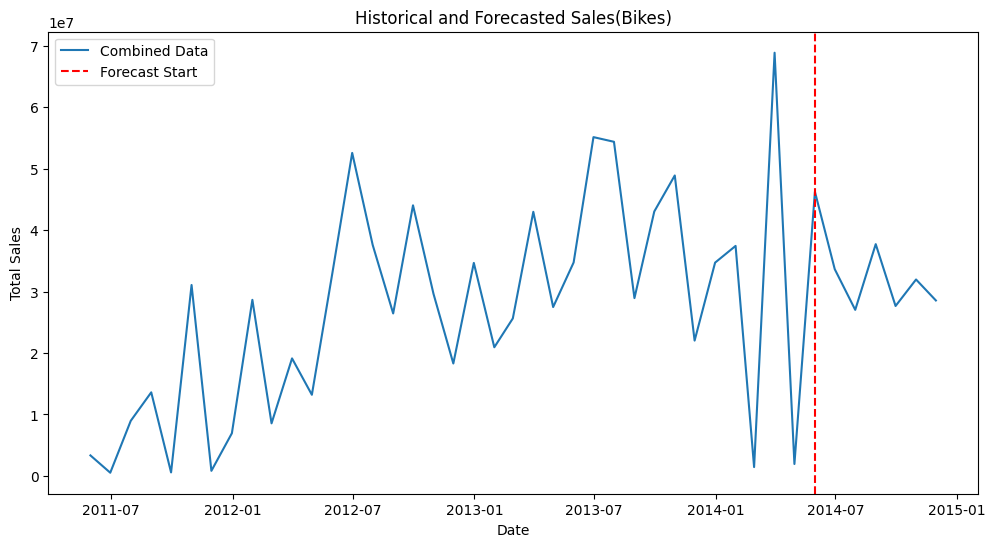

In [62]:
# Combine historical and forecast data
combined = pd.concat([monthly_sales_by_category['Bikes'], forecast_series], axis=0)

# Plot combined data
plt.figure(figsize=(12, 6))
plt.plot(combined, label='Combined Data')
plt.axvline(x=monthly_sales.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('Historical and Forecasted Sales(Bikes)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


C:\Users\Hi There\AppData\Local\Temp\ipykernel_36488\1522606818.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


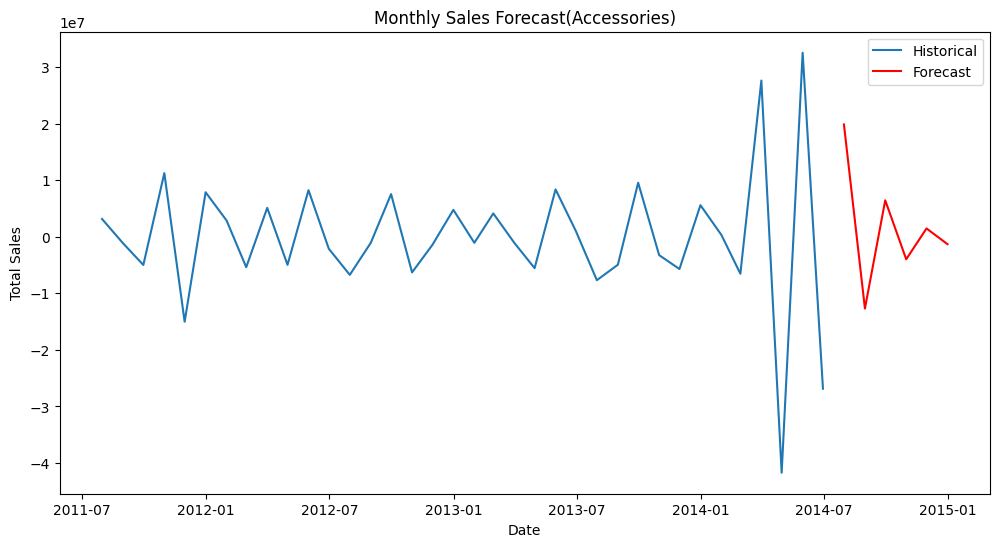

In [63]:
# Forecasting
forecast_steps = 6
forecast = model_fit_accessories.forecast(steps=forecast_steps)

# Create future dates
last_date = monthly_sales_by_category['Accessories'].index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Create forecast series
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_by_category['Accessories'], label='Historical')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Monthly Sales Forecast(Accessories)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

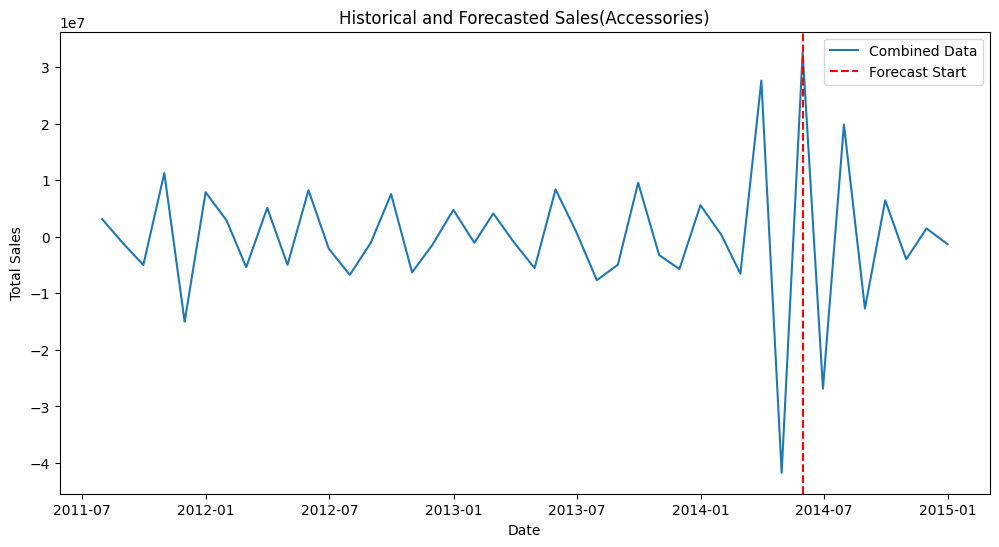

In [64]:
# Combine historical and forecast data
combined = pd.concat([monthly_sales_by_category['Accessories'], forecast_series], axis=0)

# Plot combined data
plt.figure(figsize=(12, 6))
plt.plot(combined, label='Combined Data')
plt.axvline(x=monthly_sales.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('Historical and Forecasted Sales(Accessories)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


C:\Users\Hi There\AppData\Local\Temp\ipykernel_36488\3767701057.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


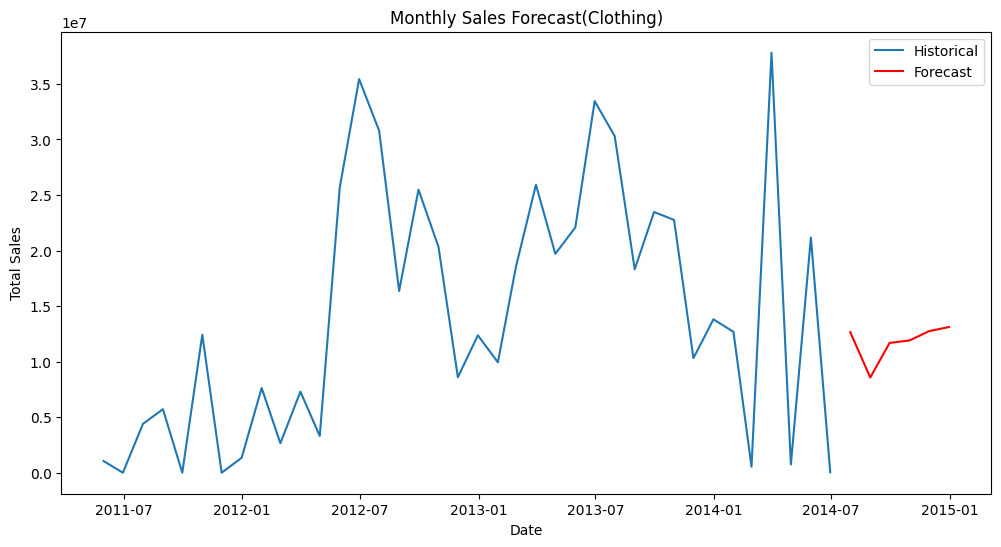

In [65]:
# Forecasting
forecast_steps = 6
forecast = model_fit_clothing.forecast(steps=forecast_steps)

# Create future dates
last_date = monthly_sales_by_category['Clothing'].index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Create forecast series
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_by_category['Clothing'], label='Historical')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Monthly Sales Forecast(Clothing)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

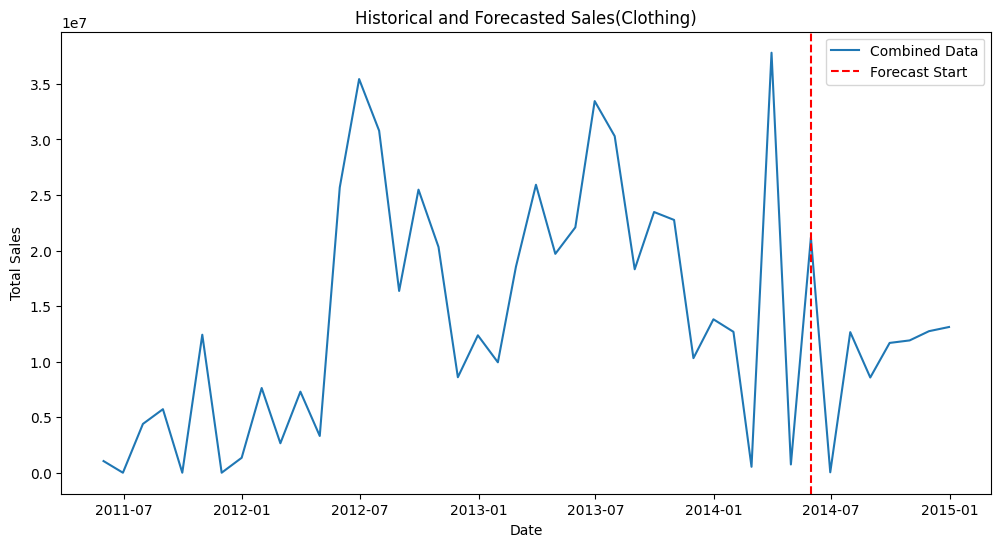

In [66]:
# Combine historical and forecast data
combined = pd.concat([monthly_sales_by_category['Clothing'], forecast_series], axis=0)

# Plot combined data
plt.figure(figsize=(12, 6))
plt.plot(combined, label='Combined Data')
plt.axvline(x=monthly_sales.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('Historical and Forecasted Sales(Clothing)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


C:\Users\Hi There\AppData\Local\Temp\ipykernel_36488\2617882095.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


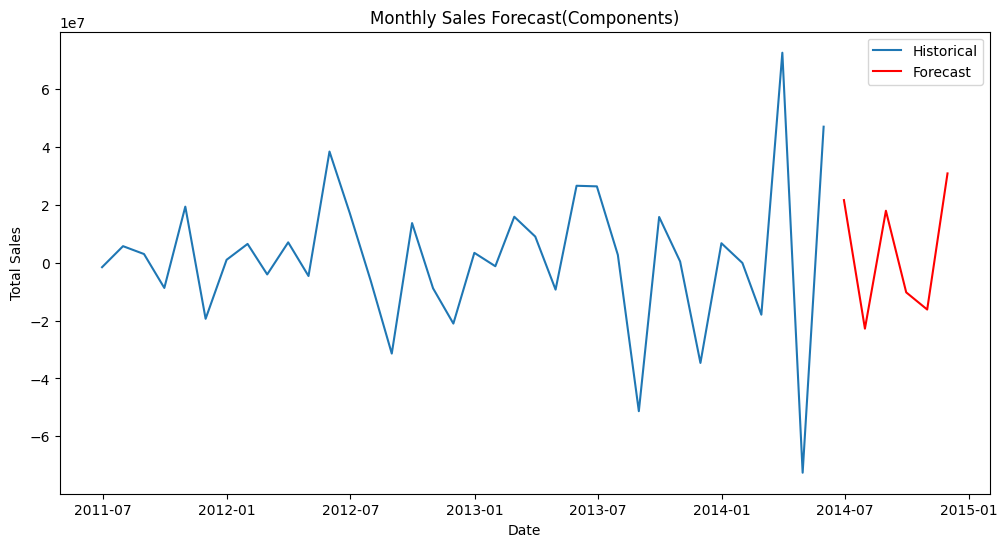

In [67]:
# Forecasting
forecast_steps = 6
forecast = model_fit_components.forecast(steps=forecast_steps)

# Create future dates
last_date = monthly_sales_by_category['Components'].index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Create forecast series
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_by_category['Components'], label='Historical')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Monthly Sales Forecast(Components)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

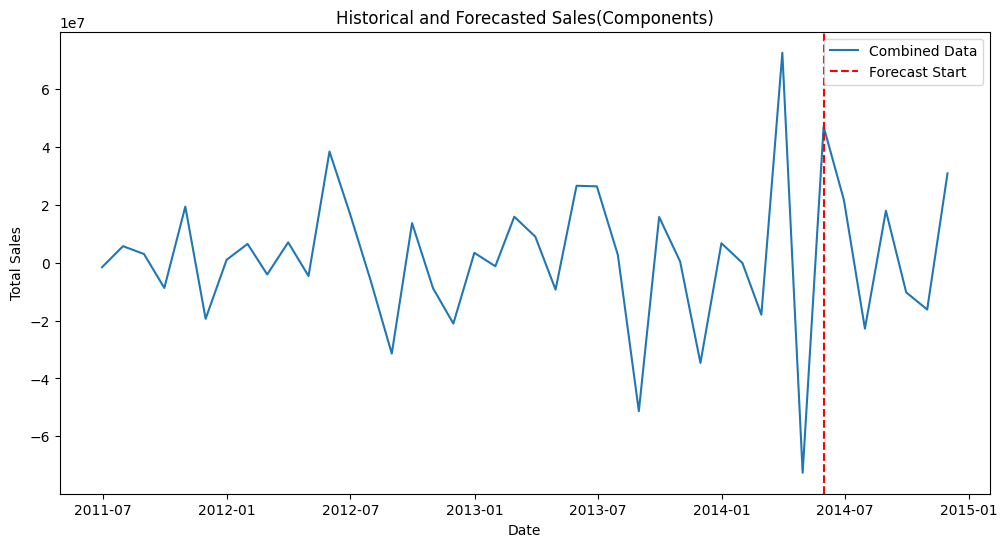

In [68]:
# Combine historical and forecast data
combined = pd.concat([monthly_sales_by_category['Components'], forecast_series], axis=0)

# Plot combined data
plt.figure(figsize=(12, 6))
plt.plot(combined, label='Combined Data')
plt.axvline(x=monthly_sales.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('Historical and Forecasted Sales(Components)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()
